In [1]:
%load_ext autoreload
%autoreload 2

import av
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from model import estimate, Network

## Functions

In [12]:
def read_flow_file(file_path):
    """
    Read a flow file that was written with the format:
    - 4-byte header (80, 73, 69, 72) as uint8
    - 2 int32 values for width and height
    - Float32 flow data
    
    Parameters:
    file_path (str): Path to the flow file
    
    Returns:
    numpy.ndarray: Flow data with shape (2, height, width)
    """
    with open(file_path, 'rb') as f:
        # Read the header (4 bytes)
        header = np.fromfile(f, dtype=np.uint8, count=4)
        
        # Verify the header is correct (80, 73, 69, 72)
        if not np.array_equal(header, np.array([80, 73, 69, 72], np.uint8)):
            raise ValueError("Invalid flow file format - header mismatch")
        
        # Read the width and height (2 int32 values)
        width, height = np.fromfile(f, dtype=np.int32, count=2)
        
        # Read the flow data
        flow_data = np.fromfile(f, dtype=np.float32)
        
        # Reshape the data - original shape was (height, width, 2)
        # so we need to reshape and transpose to get (2, height, width)
        flow_data = flow_data.reshape(height, width, 2).transpose(2, 0, 1)
        
    return flow_data

def flow2rgb(flow):
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Create HSV image where hue is direction and value is magnitude
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = angle * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255                      # Saturation (full)
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value (magnitude)

    # Convert HSV to RGB for visualization
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def rgb2flow(rgb_image):
    # Convert RGB to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Extract components
    h = hsv[..., 0] * np.pi / 90.0  # Convert hue to angle (reverse of angle * 180 / np.pi / 2)
    s = hsv[..., 1]  # Saturation (not used in conversion)
    v = hsv[..., 2]  # Value represents magnitude

    # Create flow matrix with same shape as input but with 2 channels
    flow = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 2), dtype=np.float32)

    # Convert polar coordinates (angle and magnitude) back to cartesian (x,y)
    magnitude = v  # Assuming magnitude was normalized to 0-255 range
    flow[..., 0] = magnitude * np.cos(h)  # x component
    flow[..., 1] = magnitude * np.sin(h)  # y component

    return flow


def flowvid2rgb(flow_vid):
    return np.stack([flow2rgb(f) for f in flow_vid])


def read_video_file(video_path):
    container = av.open(video_path)
    frames = []

    for idx, frame in enumerate(container.decode(video=0)):
        frames.append(frame.to_ndarray(format='rgb24'))

    container.close()
    return np.stack(frames)


def preprocess_video(video):
    # convert RGB to BGR by reversing the last channel 🤯
    video = video[:, :, :, ::-1]
    # change T x H x W x C 
    video = video.transpose(0, 3, 1, 2)
    # normalise 0-1
    return torch.tensor(video / 255, dtype=torch.float32)


def preprocess_batch(batch_video):
    return torch.stack([preprocess_video(v) for v in batch_video])

def estimate_flo_video(video):
    flo = []
    frame1 = video[0]
    for frame2 in video[1:]:
        frame2 = frame2, dtype=torch.float32
        flo_frame = estimate(frame1, frame2)
        flo.append(flo_frame.detach().cpu().numpy())
        frame1 = frame2
        
        
    return np.stack(flo)

# Testing LiteFlowNet2

In [3]:
out_flo = read_flow_file('out.flo')

flo_rgb = flow2rgb(out_flo.transpose(1, 2, 0))

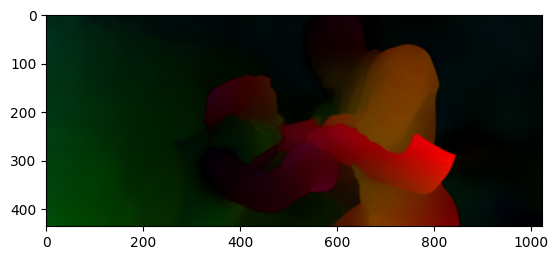

In [4]:
plt.imshow(flo_rgb)

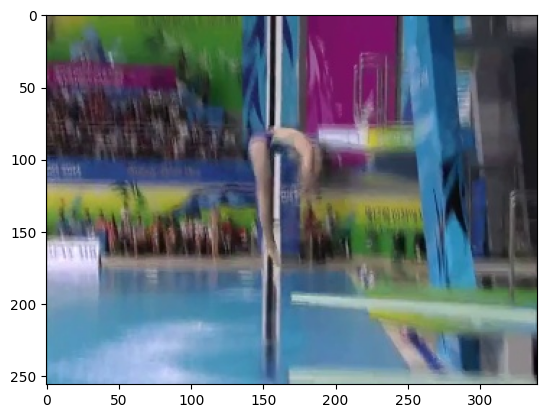

In [5]:
plt.imshow(Image.open('images/img_00001.jpg'))

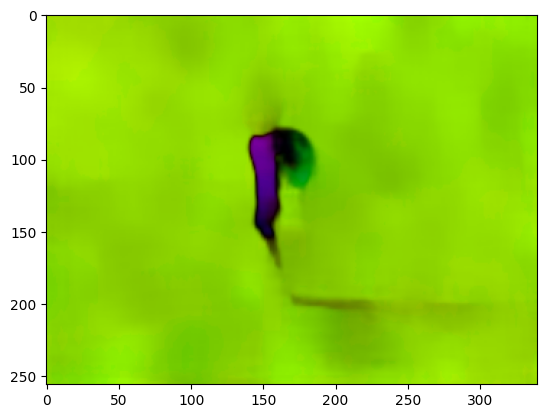

In [6]:
out_flo = read_flow_file('out_01.flo')

flo_rgb = flow2rgb(out_flo.transpose(1, 2, 0))
plt.imshow(flo_rgb)

In [10]:
filename = 'flo_rgb_000001.jpg'
Image.fromarray(flo_rgb).save(filename)

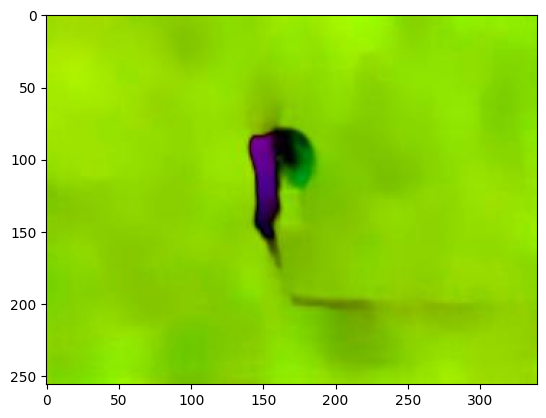

In [11]:
flo_rgb_from_file = Image.open(filename)
plt.imshow(flo_rgb_from_file)

In [15]:
flo = rgb2flow(np.array(flo_rgb_from_file))

flo.shape

(256, 340, 2)

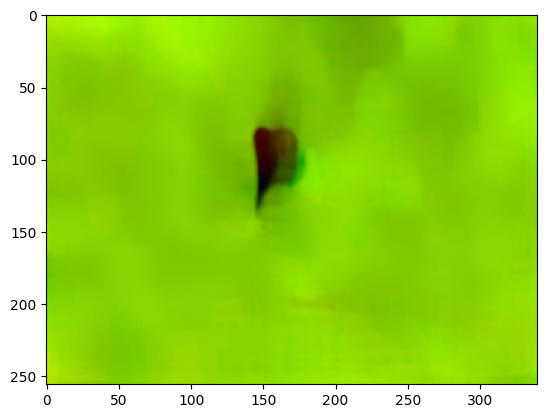

In [6]:
out_flo = read_flow_file('out_02.flo')

flo_rgb = flow2rgb(out_flo.transpose(1, 2, 0))
plt.imshow(flo_rgb)

# OF from Videos

In [5]:
video = read_video_file('./videos/_8Vy3dlHg2w_00000.mp4')
video.shape

(76, 480, 640, 3)

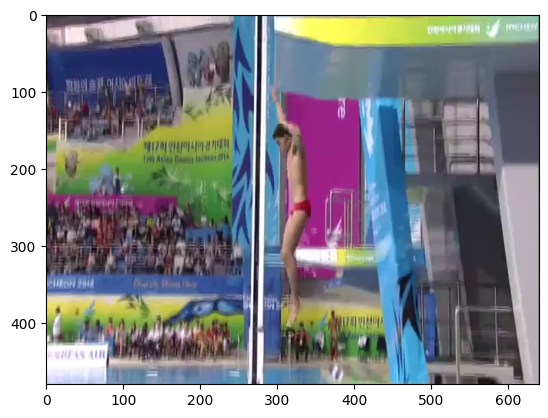

In [6]:
vid = video[:, :, :, ::]
plt.imshow(vid[0])

In [23]:
flo = estimate_flo_video(video)

In [58]:
np.save('_8Vy3dlHg2w_00000.flo', flo)

In [26]:
flo.shape

(75, 2, 480, 640)

In [30]:
flo_rgb = flo.transpose(0, 2, 3, 1)
flo_rgb = np.stack([flow2rgb(f) for f in flo_rgb])
flo_rgb.shape

(75, 480, 640, 3)

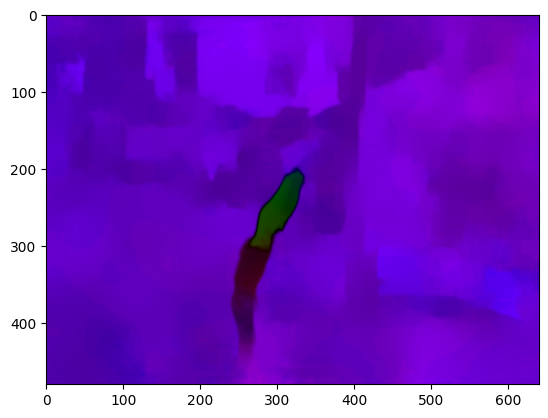

In [56]:
plt.imshow(flo_rgb[52])

In [59]:
video = read_video_file('./videos/-mmq0PT-u8k_00144.mp4')
video.shape

(102, 480, 640, 3)

In [60]:
flo = estimate_flo_video(video)

In [61]:
flo_rgb = flo.transpose(0, 2, 3, 1)
flo_rgb = np.stack([flow2rgb(f) for f in flo_rgb])
flo_rgb.shape

(101, 480, 640, 3)

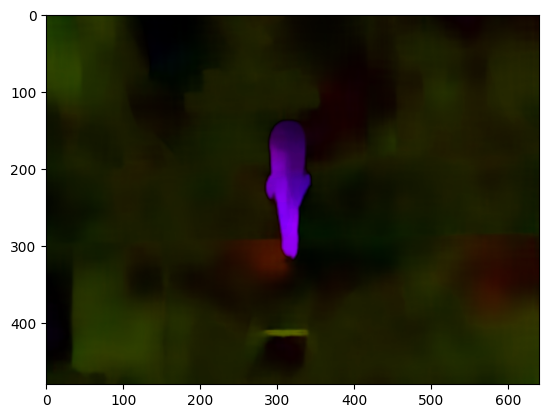

In [71]:
plt.imshow(flo_rgb[8])

In [72]:
np.save('-mmq0PT-u8k_00144.flonet2', flo)

In [73]:
video = read_video_file('./videos/_8Vy3dlHg2w_00001.mp4')
video.shape

(88, 480, 640, 3)

In [74]:
flo = estimate_flo_video(video)

In [75]:
flo_rgb = flo.transpose(0, 2, 3, 1)
flo_rgb = np.stack([flow2rgb(f) for f in flo_rgb])
flo_rgb.shape

(87, 480, 640, 3)

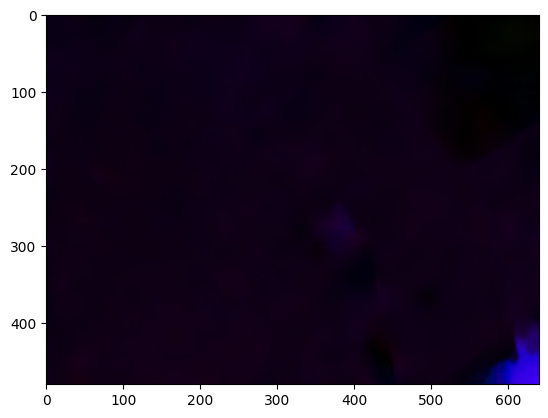

In [81]:
plt.imshow(flo_rgb[4])

In [82]:
np.save('_8Vy3dlHg2w_00001.flonet2', flo)

# Batch Mode

In [5]:
video = read_video_file('./videos/-mmq0PT-u8k_00144.mp4')
video = video[:8]
video.shape, video.dtype

((8, 480, 640, 3), dtype('uint8'))

In [6]:
xb1 = video[:-1]
xb2 = video[1:]
xb1.shape, xb2.shape

((7, 480, 640, 3), (7, 480, 640, 3))

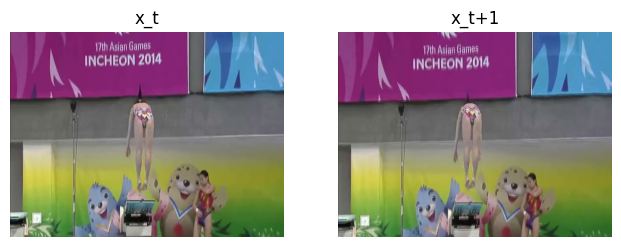

In [7]:
idx = 0
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('x_t')
plt.axis('off')
plt.imshow(xb1[idx])

# Display as BGR (convert to RGB for matplotlib)
plt.subplot(132)
plt.title('x_t+1')
plt.axis('off')
plt.imshow(xb2[idx])  # Reverse the channels
plt.show()

In [9]:
Image.fromarray(xb1[0]).save('diver.png')

In [3]:
device = torch.device('cuda:2')

In [7]:
xb = preprocess_video(video).to(device)
xbb1 = xb[:-1]
xbb2 = xb[1:]
# print(torch.cuda.memory_summary())
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())
xbb1.dtype, xbb1.shape, xbb2.dtype, xbb2.shape, xbb2.device

(torch.float32,
 torch.Size([7, 3, 480, 640]),
 torch.float32,
 torch.Size([7, 3, 480, 640]),
 device(type='cuda', index=2))

In [4]:
model = Network().to(device).train(False)

In [9]:
flob = model(xbb1, xbb2)

In [10]:
flob.shape

torch.Size([7, 2, 240, 320])

In [11]:
flow_rgb = flowvid2rgb(flob.detach().cpu().numpy().transpose(0, 2, 3, 1))

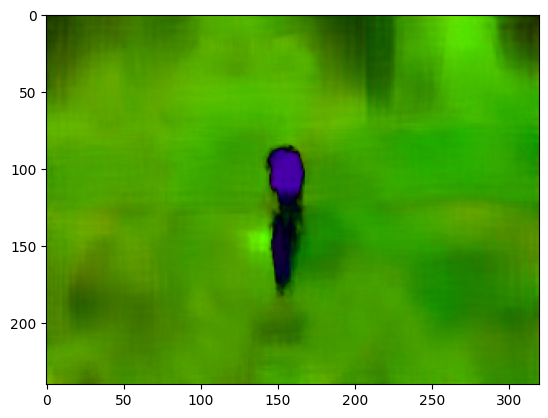

In [12]:
plt.imshow(flow_rgb[0])

In [6]:
videos = ['./videos/-mmq0PT-u8k_00144.mp4', './videos/_8Vy3dlHg2w_00000.mp4']

flobb = []
for filename in videos:
    video = read_video_file(filename)
    x = preprocess_video(video[:8]).to(device)
    flo = model(x[:-1],x[1:])
    flobb.append(flo)
    

flobb = torch.stack(flobb)
flobb.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 66.00 MiB. GPU  has a total capacity of 14.65 GiB of which 54.88 MiB is free. Process 2129476 has 54.00 MiB memory in use. Process 2289481 has 14.53 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 234.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)